# 6CS012 Tutorial 9: Sentiment Analysis on Twitter Data

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
def load_data(path):
    """Load CSV dataset. Expects 'text' and 'sentiment' columns."""
    df = pd.read_csv(path)
    df.dropna(subset=['text', 'sentiment'], inplace=True)
    return df


In [4]:
def preprocess_text(text):
    """Clean tweet text: lowercase, remove URLs/mentions/hashtags/numbers/punct, lemmatize."""
    txt = text.lower()
    txt = re.sub(r'http\S+|www\.\S+|https\S+', '', txt)
    txt = re.sub(r'@\w+|#', '', txt)
    txt = re.sub(r'[^\w\s]', '', txt)
    txt = re.sub(r'\d+', '', txt)
    tokens = txt.split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)


In [10]:
import pandas as pd

def load_data(path='/content/trumptweets_small.csv'):
    """Load CSV of Trump tweets. Supports 'content' or 'text' columns; renames to 'text' and drops missing."""
    df = pd.read_csv(path)

    if 'content' in df.columns:
        df.rename(columns={'content': 'text'}, inplace=True)
    elif 'text' not in df.columns:
        raise ValueError("CSV must contain a 'text' or 'content' column.")

    df.dropna(subset=['text'], inplace=True)
    return df



In [13]:
import pandas as pd

def load_data(path='/content/trumptweets_small.csv'):
    """Load CSV of Trump tweets. Supports 'content' or 'text' columns; renames to 'text' and drops missing."""

    # Load CSV
    df = pd.read_csv(path)

    # Rename possible text column
    if 'content' in df.columns:
        df = df.rename(columns={'content': 'text'})
    if 'text' not in df.columns:
        raise ValueError("Dataset must contain a 'content' or 'text' column.")

    # Drop missing values in 'text'
    df.dropna(subset=['text'], inplace=True)

    return df


In [14]:
# Load and clean data
data = load_data()

In [15]:
# Preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    """Clean tweet text: lowercase, remove URLs/mentions/hashtags/numbers/punctuation, lemmatize."""
    txt = text.lower()
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt)
    txt = re.sub(r'@\w+|#', '', txt)
    txt = re.sub(r'[^\w\s]', '', txt)
    txt = re.sub(r'\d+', '', txt)
    tokens = txt.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

In [16]:
# Apply cleaning
data['cleaned'] = data['text'].apply(preprocess_text)

In [18]:
print(data.columns)


Index(['id', 'link', 'text', 'date', 'retweets', 'favorites', 'mentions',
       'hashtags', 'geo', 'cleaned'],
      dtype='object')


In [19]:
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply to your cleaned text column
data['sentiment'] = data['cleaned'].apply(get_sentiment)


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['label'] = le.fit_transform(data['sentiment'])


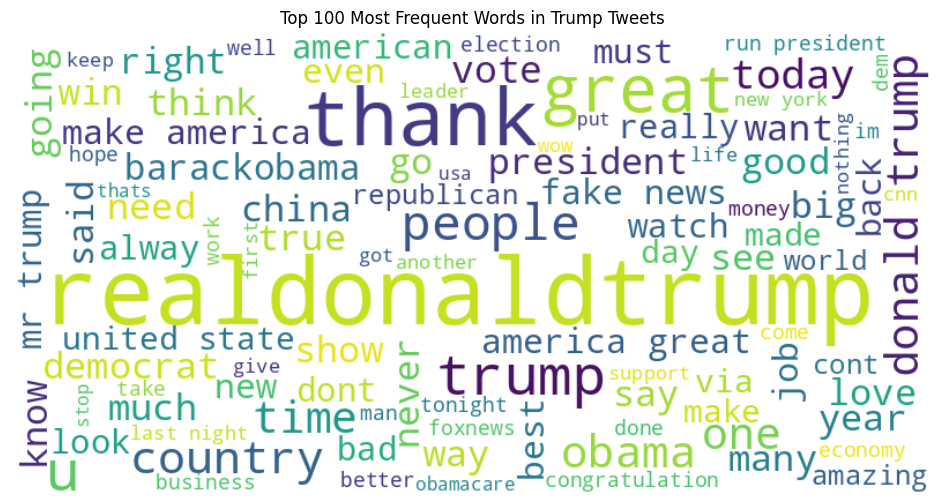

In [21]:
# Visualize most frequent words
all_words = ' '.join(data['cleaned'])
wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words in Trump Tweets')
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned'], data['label'], test_size=0.2, random_state=42
)
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [30]:
# Padding length at 95th percentile
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [31]:
def build_rnn_model(vocab_size=10000, embed_dim=128, input_length=None):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=input_length),
        SimpleRNN(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:

def build_lstm_model(vocab_size=10000, embed_dim=128, input_length=None):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=input_length),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model(input_length=max_len)
lstm_model = build_lstm_model(input_length=max_len)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
callbacks = [
    ModelCheckpoint('best_rnn.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

In [34]:
print('Training Simple RNN...')
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    epochs=10, batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

Training Simple RNN...
Epoch 1/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2891 - loss: -5.1221
Epoch 1: val_accuracy improved from -inf to 0.27872, saving model to best_rnn.h5


463/463 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.2891 - loss: -5.1292 - val_accuracy: 0.2787 - val_loss: -14.5959
Epoch 2/10
461/463 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2928 - loss: -16.6796
Epoch 2: val_accuracy improved from 0.27872 to 0.27933, saving model to best_rnn.h5


463/463 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.2928 - loss: -16.6963 - val_accuracy: 0.2793 - val_loss: -25.5585
Epoch 3/10
462/463 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2853 - loss: -27.7765
Epoch 3: val_accuracy improved from 0.27933 to 0.27964, saving model to best_rnn.h5


463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2853 - loss: -27.7895 - val_accuracy: 0.2796 - val_loss: -36.9835
Epoch 4/10
462/463 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2919 - loss: -39.7886
Epoch 4: val_accuracy did not improve from 0.27964
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2919 - loss: -39.8001 - val_accuracy: 0.2784 - val_loss: -48.2511
Epoch 5/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2938 - loss: -51.0890
Epoch 5: val_accuracy improved from 0.27964 to 0.28116, saving model to best_rnn.h5


463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2938 - loss: -51.0954 - val_accuracy: 0.2812 - val_loss: -59.3702
Epoch 6/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2928 - loss: -63.3295
Epoch 6: val_accuracy did not improve from 0.28116
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.2928 - loss: -63.3345 - val_accuracy: 0.2812 - val_loss: -69.9610
Epoch 7/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2989 - loss: -74.4428
Epoch 7: val_accuracy improved from 0.28116 to 0.28298, saving model to best_rnn.h5


463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2989 - loss: -74.4487 - val_accuracy: 0.2830 - val_loss: -80.3272
Epoch 8/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2986 - loss: -86.4967
Epoch 8: val_accuracy did not improve from 0.28298
463/463 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.2986 - loss: -86.5016 - val_accuracy: 0.2827 - val_loss: -91.6140
Epoch 9/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3039 - loss: -97.2156
Epoch 9: val_accuracy did not improve from 0.28298
463/463 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.3039 - loss: -97.2225 - val_accuracy: 0.2830 - val_loss: -103.2280
Epoch 10/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3049 - loss: -108.1367
Epoch 10: val_accuracy did not improve from 0.28298
463/463 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.3049 - loss: -108.1447 - val_accuracy: 0.2815 - val_loss: -114.5204
Restoring model weights from the end of the best epoch: 10.


In [35]:
print('Training Simple RNN...')
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    epochs=1, batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

Training Simple RNN...
462/463 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3007 - loss: -122.4519
Epoch 1: val_accuracy did not improve from 0.28298
463/463 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3007 - loss: -122.4570 - val_accuracy: 0.2827 - val_loss: -126.7105
Restoring model weights from the end of the best epoch: 1.


In [36]:
# Plotting function
def plot_history(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

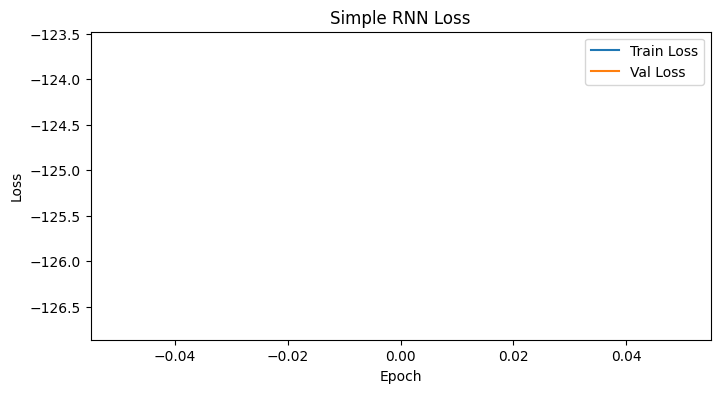

NameError: name 'lstm_history' is not defined

In [37]:
plot_history(rnn_history, 'Simple RNN Loss')
plot_history(lstm_history, 'LSTM Loss')


In [38]:
print('----- RNN Evaluation -----')
def evaluate(model, X, y, label_names):
    preds = (model.predict(X) > 0.5).astype(int).flatten()
    print('Accuracy:', accuracy_score(y, preds))
    print('Confusion Matrix:\n', confusion_matrix(y, preds))
    print('Classification Report:\n', classification_report(y, preds, target_names=label_names))


----- RNN Evaluation -----


In [39]:

evaluate(rnn_model, X_test_pad, y_test, le.classes_)
print('----- LSTM Evaluation -----')
evaluate(lstm_model, X_test_pad, y_test, le.classes_)


258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy: 0.2880243161094225
Confusion Matrix:
 [[  67 1361    0]
 [   7 2302    0]
 [  38 4450    0]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.05      0.09      1428
     neutral       0.28      1.00      0.44      2309
    positive       0.00      0.00      0.00      4488

    accuracy                           0.29      8225
   macro avg       0.29      0.35      0.18      8225
weighted avg       0.18      0.29      0.14      8225

----- LSTM Evaluation -----


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy: 0.2588449848024316
Confusion Matrix:
 [[1189  239    0]
 [1369  940    0]
 [3360 1128    0]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.20      0.83      0.32      1428
     neutral       0.41      0.41      0.41      2309
    positive       0.00      0.00      0.00      4488

    accuracy                           0.26      8225
   macro avg       0.20      0.41      0.24      8225
weighted avg       0.15      0.26      0.17      8225



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
import tkinter as tk
from tkinter import messagebox

In [41]:
def predict_single(text, model, tokenizer, max_len):
    seq = tokenizer.texts_to_sequences([preprocess_text(text)])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(pad)[0]
    val = pred if np.isscalar(pred) else pred[0]
    return 'Positive' if val > 0.5 else 'Negative'

In [44]:
def predict_interface(text):
    """Gradio-compatible prediction function."""
    return predict_single(text, lstm_model, tokenizer, max_len)


In [48]:
!pip install gradio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00


In [49]:
import gradio as gr

# Dummy prediction function for demo purposes
def predict_interface(text):
    return "Positive"  # Replace with your actual model prediction logic

iface = gr.Interface(
    fn=predict_interface,
    inputs=gr.Textbox(label="Enter tweet"),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Trump Tweet Sentiment Predictor",
    description="Enter a Trump tweet to predict its sentiment (Positive/Negative/Neutral)."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://042f8678465e68b635.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [50]:
iface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://042f8678465e68b635.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
